# MARKET SCR Backtesting

EIOPA 2025: https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX:02009L0138-20250117
- Information on Market Risk Submodule is in Annex IV. It links to Article 105(5)

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.insert(0, parent_dir)

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os

In [2]:
from standard_formula.sf import calculate_market_scr

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0,1,2,3,4,5,6] 
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:400]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

In [6]:
entire_df = pd.concat([returns_df, test_returns_df])

test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2019-01-03,0.000449,-0.016792,-0.017998,0.003209,-0.002739,0.000322,-0.00001
2019-01-04,0.017480,0.029982,0.025947,-0.004488,-0.002372,0.006997,-0.00001
2019-01-07,0.004902,0.016009,0.003607,0.000024,-0.001484,0.006122,-0.00003
2019-01-08,0.015357,0.012384,0.010125,-0.000592,-0.001053,0.004209,-0.00001
2019-01-09,-0.003836,0.003621,0.001916,0.001019,0.001938,0.004650,-0.00001


In [7]:
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

In [8]:
n_windows = len(historical_df) - 252 + 1

window_start_dates = []
window_end_dates = []
realized_bof_values = []
realized_delta_bof_values_1 = []

for t in range(n_windows):
    # Get window data
    window_data = historical_df.iloc[t:t+252]
    window_start_date = historical_df.index[t]
    window_end_date = historical_df.index[t+252-1]
    
    # Get returns and EONIA for this window
    window_returns = (window_data * weights).sum(axis=1)
    window_eonia = window_data.iloc[:, -1]
    
    # Calculate portfolio value at the end of the window
    # Starting from assets_0 each time
    portfolio_value_end = assets_0 * (1 + window_returns).prod() # This is analogous to the yearly return
    
    # Calculate liabilities at the end of the window
    # Starting from liabilities_0 each time
    liabilities_end = liabilities_0 * (1 + window_eonia).prod()
    
    # Calculate BOF at the end of the window
    bof_end = portfolio_value_end - liabilities_end
    delta_bof = bof_end - bof_0
    
    # Store results
    window_start_dates.append(window_start_date)
    window_end_dates.append(window_end_date)
    realized_bof_values.append(bof_end)
    realized_delta_bof_values_1.append(delta_bof)

### Calculating the market risk using standard formula for every window.

In [9]:
durations = {
    'gov_bonds': 7.29,
    'IG_corp_bonds': 5.90,
    'HY_corp_bonds': 3.14
}

name_mapping = {
    'REEL' : 'real_estate',
    'PE': 'other_equity',
    'MSCIWORLD': 'global_equity',
    'IG' : 'IG_corp_bonds',
    'GOV' : 'gov_bonds',
    'HY' : 'HY_corp_bonds',
    'EONIA' : 'money_market'
}

In [10]:
asset_values = {}

for i, j in enumerate(historical_df.columns):
    correct_name = name_mapping[j]
    correct_weight = weights[i]
    asset_values[correct_name] = correct_weight

asset_values

{'real_estate': np.float64(0.14285714285714285),
 'other_equity': np.float64(0.14285714285714285),
 'global_equity': np.float64(0.14285714285714285),
 'IG_corp_bonds': np.float64(0.14285714285714285),
 'gov_bonds': np.float64(0.14285714285714285),
 'HY_corp_bonds': np.float64(0.14285714285714285),
 'money_market': np.float64(0.14285714285714285)}

### Generating SCR values

In [11]:
scenarios_results = {}
asset_names = list(returns_df.columns)

portfolio_scr_results = {}  # key: date, value: scr

i = 0
for date in tqdm(test_returns_df.index, desc='Processing Dates', unit='Date'):
    i += 1

    org_date = date
    date = str(date.date())
    for asset in asset_names:
        scr = calculate_market_scr(asset_values=asset_values, durations=durations, start_test_date=date)
        if org_date != test_returns_df.index[-1]:
            next_day = test_returns_df.index[test_returns_df.index.get_loc(org_date) + 1]
        else:
            print(f"Warning: {date} is the last day in the index, no next day available.")
            continue
    
    if not scr: continue
    else: 
        scr = -scr['Total Market SCR'] * assets_0

    if scr > 0: scr = 0.0
    
    portfolio_scr_results[next_day] = scr

Processing Dates: 100%|██████████| 400/400 [01:08<00:00,  5.88Date/s]

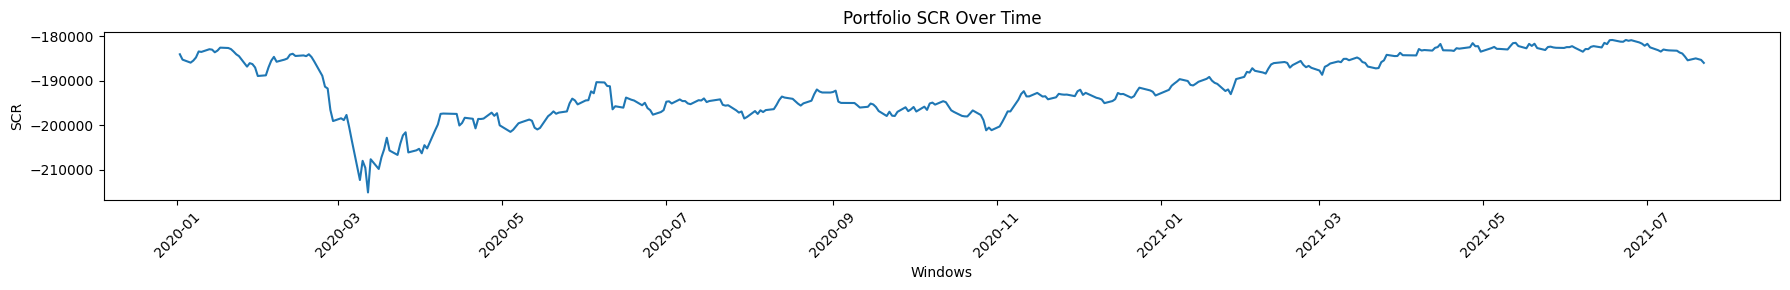

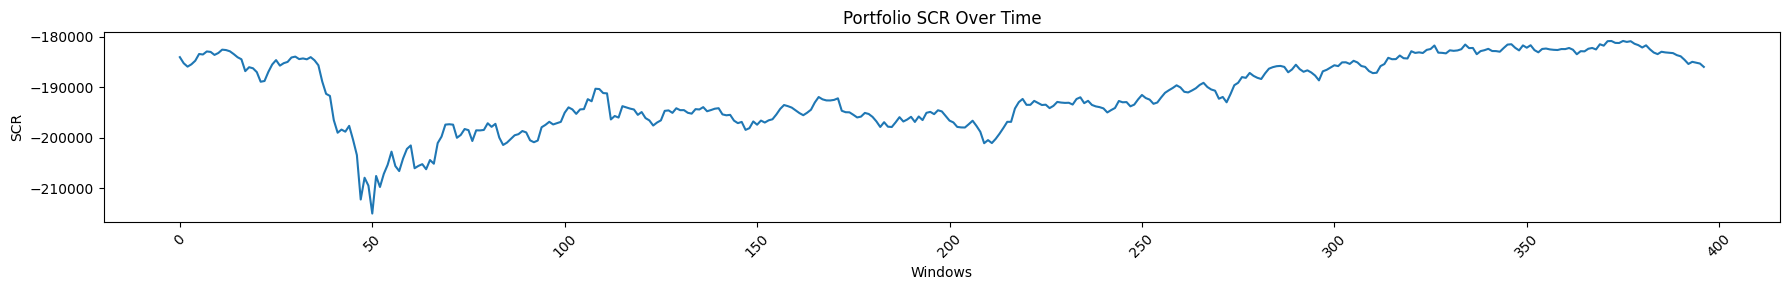

In [12]:
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 3))
plt.plot(test_returns_df.index[:-3], scr_values, linestyle='-')
plt.xlabel("Windows")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(scr_values, linestyle='-')
plt.xlabel("Windows")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

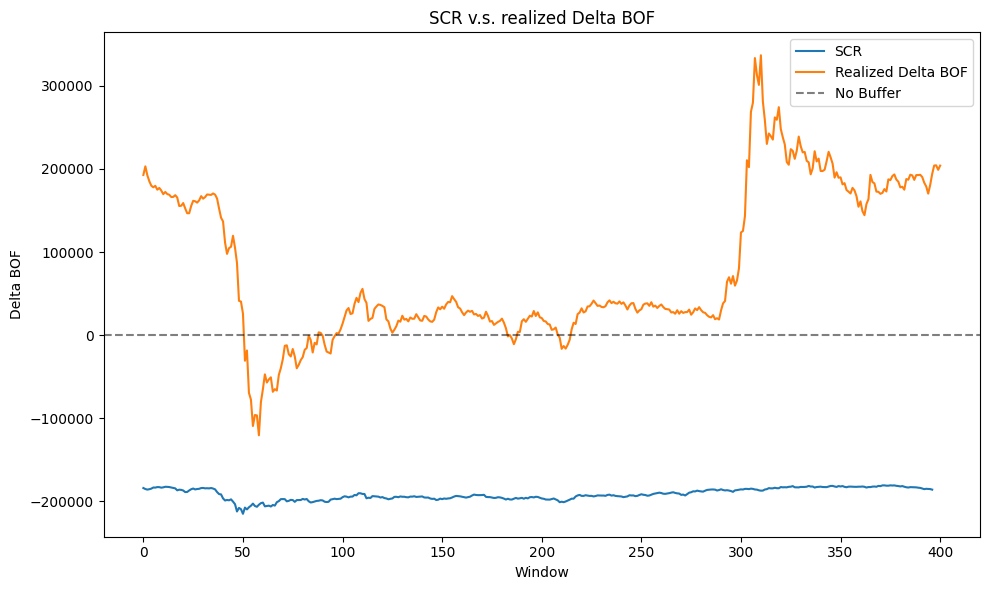

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(scr_values, linestyle='-', label='SCR')
plt.plot(realized_delta_bof_values_1, linestyle='-', label='Realized Delta BOF')

# Add a vertical dashed line - you can change the position as needed
plt.axhline(y=0, color='black', linestyle='--', label='No Buffer', alpha=0.5)

plt.xlabel("Window")
plt.ylabel("Delta BOF")
plt.title("SCR v.s. realized Delta BOF")
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

In [14]:
from backtesting.perform_var_tests import evaluate_risk_metrics

In [15]:
evaluate_risk_metrics(scr_values, realized_delta_bof_values_1)

breaches [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,Metric,Value,Description,Pass/Fail
0,Balanced SCR Loss (α=0.25),67367.4081,Penalty for under-conservatism,
1,Balanced SCR Loss (α=0.5),134734.8162,Penalty for balanced,
2,Balanced SCR Loss (α=0.75),202102.2243,Penalty for capital inefficiency,
3,Kupiec POF Test p-value,0.0460,Tests if breach frequency matches expected,❌
4,Indep. Test p-value,1.0000,Tests if breaches are independent,✅
5,Cond. Coverage p-value,0.1367,Combined test of frequency and independence,✅
6,Lopez Average Loss,0.0000,Quadratic loss function for VaR breaches,
7,Breach Rate,0.0000,Proportion of time when Delta BOF < SCR,
